# Datamodule Testing

This is a running example of how to use the DataModule. For the datamodule, you can use either synthetic datasets or real-world data (only synthetic is implemented at the moment!). 




In [1]:
import sys
sys.path.append('..')
%load_ext autoreload


## Synthetic data

For synthetic data we generate structural causal models using an SCM generator. You can check out the [tutorial](./scm_tutorial.ipynb) on how to use this generator. Buttom line, you have to give your datamodule the name of the SCM generator class which is being used alongside the constructor arguments as `scm_generator_class` and `scm_generator_args`. This will create a generator according to the scheme and sample an SCM using the seed defined in the datamodule to work with it.


In [2]:
## Synthetic scm arguments
scm_generator_class = 'ocd.data.affine_additive.scm.AffineAdditiveSCMGenerator'

# an example of a generation scheme:
graph_generation_scheme = dict(
    graph_generator_type='erdos_renyi',
    graph_generator_args=dict(
        n=5,
        p=0.7
    )
)

# scm_generator kwargs
scm_generator_kwargs = dict(
    **graph_generation_scheme,
    function_type='linear_additive',
    noise_type='laplace',
    functional_form_generator_args=dict(
        weight_low=0.2,
        weight_high=1.0,
        noise_std_low=0.2,
        noise_std_high=1.0,
        noise_mean_low=0.2,
        noise_mean_high=1.0
    )
)

After setting up the SCM, you can give your datamodule a set of parameters to simulate observational and interventional data. The parameter `observation_size` will denote the number of observational samples simulated from the SCM. On the other hand, you might have a set of local interventions, better known as, interventional episodes. The number of such interventional eposides can be set using `interventional_episode_count` and for each interventional episode the number of samples are denoted by `interventional_episode_size`. The actual intervention itself is defined as a callable function using `intervention_function` that gets input of form `(inputs, params)` where `inputs[0]` is the noise variable and `inputs[1..]` are the endogenous variables of the parents; furthermore, `params[0]` will denote the parameters for the current node and `params[1..]` will denote the parameters corresponding to the edge connecting that particular parent to our current node. You can check the intervention section of the [tutorial](./scm_tutorial.ipynb) for further clarification.

*Note*: By default, the intervention is set off and the dataset obtained will only be observational.

In [3]:
observation_size = 100

interventional_episode_count = 2
interventional_episode_size = 30

# hard intervention setting the value of the intervened node to 2.
intervention_function = 'lambda inputs, params: 2'

Without further ado, let's create the datamodule itself:

In [4]:
%autoreload
from ocd.data.module import OCDDataModule


dm = OCDDataModule(
    seed=100,
    scm_generator_class=scm_generator_class,
    scm_generator_args=scm_generator_kwargs,
    observation_size=observation_size,
    interventional_episode_count=interventional_episode_count,
    interventional_episode_size=interventional_episode_size,
    intervention_function=intervention_function,
    batch_size=64,
    num_workers=0,  # set to 0 for no multiprocessing
    val_size=0,  # 10% of data for validation, or use int for exact number of samples, set to 0 for no validation
)
dm.setup('fit')

Now using `dm.datasets` you will have access to the observational and interventional data. For example, `dm.datasets[0]` will give you the observational data:

In [5]:
dm.datasets[0].samples

,0,1,2,3,4
0,0.406766,0.674384,0.488556,1.371651,0.178411
1,0.383537,0.643449,0.451550,1.281277,0.167735
2,0.457924,0.742513,0.570054,1.570682,0.201922
3,0.311068,0.546939,0.336101,0.999333,0.134430
4,-0.122281,-0.030165,-0.354256,-0.686623,-0.064727
...,...,...,...,...,...
95,0.972425,1.427691,1.389693,3.572365,0.438374
96,0.562659,0.881991,0.736904,1.978155,0.250055
97,0.908141,1.342082,1.287284,3.322266,0.408831
98,0.470289,0.758980,0.589753,1.618789,0.207605


You can also plot the scm corresponding to the datamodule using `dm.scm.draw()`:

x(0) = 0.55*laplace(0.68, 0.74)
---------------------

x(4) = 0.27*laplace(0.32, 0.38) + 0.21*x(0)
---------------------

x(2) = 0.39*laplace(0.33, 0.80) + 0.69*x(0) + 0.29*x(4)
---------------------

x(1) = 0.50*laplace(0.69, 0.34) + 0.88*x(4) + 0.32*x(2)
---------------------

x(3) = 0.50*laplace(0.36, 0.76) + 0.56*x(4) + 0.95*x(2) + 0.88*x(1)
---------------------



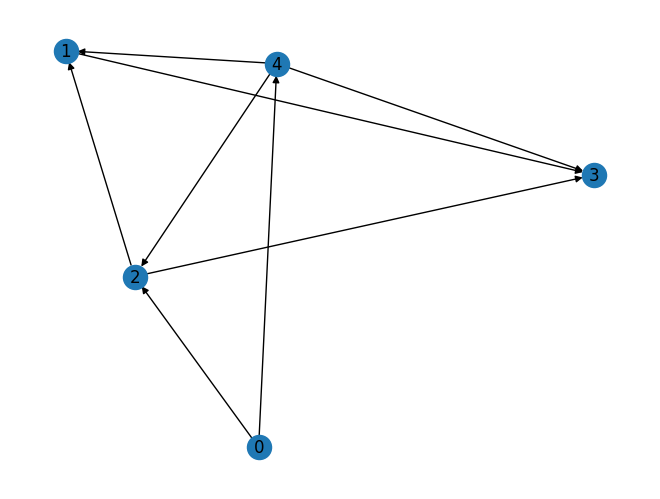

In [6]:
dm.scm.draw()

To check out the interventional dataset samples you can run the following code. Note that the intervened variable is set to $2$.

In [7]:
dm.datasets[1].samples.head()

,0,1,2,3,4
0,0.383537,2.431156,0.988123,4.391468,2
1,0.457924,2.496865,1.096616,4.622843,2
2,0.311068,2.367142,0.882427,4.166059,2
3,-0.122281,1.984351,0.250393,2.818162,2
4,-0.352278,1.781187,-0.085055,2.102776,2


In [8]:
dm.datasets[2].samples.head()

,0,1,2,3,4
0,0.457924,1.201962,2,3.338547,0.201922
1,0.311068,1.081560,2,3.056438,0.134430
2,-0.122281,0.726270,2,2.223982,-0.064727
3,-0.352278,0.537703,2,1.782161,-0.170428
4,-1.273969,-0.217962,2,0.011606,-0.594015
